In [83]:
import numpy as np
from scipy import io as sio
from matplotlib import pyplot as plt

In [84]:
import typhon as tp

In [85]:
# Set input frequency values.

# Case 1
# f_grid = np.array([18.700e9, 22.235e9, 37.000e9, 40.000e9, 50.300e9, 52.300e9, 53.600e9, 54.550e9, 55.750e9, 57.000e9, 58.400e9, 59.800e9])

# Case 2
f_grid = np.array([ 22.234e9, 22.5e9, 23.034e9, 23.834e9, 
                    25e9, 26.234e9, 28e9, 30e9, 
                    51.248e9, 51.76e9, 52.28e9, 52.804e9, 
                    53.336e9, 53.848e9, 54.4e9, 54.94e9, 
                    55.5e9, 56.02e9, 56.66e9, 57.288e9, 57.964e9, 58.8e9 ])
                   
tp.arts.xml.save(f_grid, './test_f_grid.xml')

/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/utils.py:32: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):
/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/xml/write.py:185: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):
/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/xml/write.py:197: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):


In [86]:
# Set sensor viewing angles and position.

# Case 1
# sensor_los = np.array([[171.030788, 90]])
# sensor_pos = np.array([[5334.194, 34.511312, 127.224312]])

# Case 2
sensor_los = np.array([[0, 0]]) # Looking straight up
sensor_pos = np.array([[0, 34.763892, 127.212426]]) # Bosung, Korea

tp.arts.xml.save(sensor_los, './test_sensor_los.xml')
tp.arts.xml.save(sensor_pos, './test_sensor_pos.xml')

/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/utils.py:32: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):
/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/xml/write.py:185: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):
/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/xml/write.py:214: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):


In [87]:
# Load surface and atmosphere datasets from netCDF input files. 
surface_dataset = sio.netcdf.netcdf_file('./l015v070erlounish000.2017093000.rec.nc',mmap=False)
atmosphere_dataset = sio.netcdf.netcdf_file('./l015v070erlopresh000.2017093000.rec.nc',mmap=False)

In [88]:
# Find the geolocation of the pixel that is closest to the geolocation of the sensor's line-of-sight (LOS). 

In [89]:
# Assume WGS 1984 for the reference Ellipsoid.
R_eq = 6378137 # Earth's equatorial radius, in meters
iFlttn = 298.257223563 # Inverse flattening
R_polar = R_eq * (1-1/iFlttn) # Earth's polar radius
R_polar

6356752.314245179

In [90]:
# Convert the sensor's position from polar to Cartesian coordinates.
sensor_pos_alt = sensor_pos[0][0]
sensor_pos_lat = sensor_pos[0][1]
sensor_pos_lon = sensor_pos[0][2]
sensor_pos_cart = np.array([ (R_eq+sensor_pos_alt) * np.cos(sensor_pos_lat * np.pi/180) * np.cos(sensor_pos_lon * np.pi/180), 
    (R_eq+sensor_pos_alt) * np.cos(sensor_pos_lat * np.pi/180) * np.sin(sensor_pos_lon * np.pi/180), 
    (R_polar+sensor_pos_alt) * np.sin(sensor_pos_lat * np.pi/180) ]) # Cartesian coordinates of the sensor's position
sensor_pos_cart

array([-3168820.09342986,  4172886.7780229 ,  3624594.50923623])

In [91]:
# If the sensor is on the ground looking above:
if (sensor_pos_alt == 0 and sensor_los[0][0] <= 90):
    sensor_los_gpos = sensor_pos_cart

# If the sensor is above the ground looking down: 
elif (sensor_pos_alt > 0 and sensor_los[0][0] <= 180):
    # Find the local reference vectors for the sensor's zenith and azimuth. 
    sensor_los_localZ = -np.array([sensor_pos_cart[0]/((R_eq+sensor_pos_alt)**2), 
                                   sensor_pos_cart[1]/((R_eq+sensor_pos_alt)**2), 
                                   sensor_pos_cart[2]/((R_polar+sensor_pos_alt)**2)])
    sensor_pos2NorthPole = np.array([0, 0, R_polar]) - sensor_pos_cart
    sensor_pos2North = sensor_pos2NorthPole - ((np.dot(sensor_pos2NorthPole,sensor_los_localZ) / np.dot(sensor_los_localZ,sensor_los_localZ)) * sensor_los_localZ)
    sensor_los_localX = sensor_pos2North
    sensor_los_localY = np.cross(sensor_los_localZ,sensor_los_localX)

    # Normalize the local axes for sensor_los.
    sensor_los_localZ = sensor_los_localZ / np.linalg.norm(sensor_los_localZ)
    sensor_los_localY = sensor_los_localY / np.linalg.norm(sensor_los_localY)
    sensor_los_localX = sensor_los_localX / np.linalg.norm(sensor_los_localX)

    # Calculate the sensor's LOS vector in reference to the Earth.
    sensor_los_theta = (sensor_los[0][0] - 90) * np.pi/180
    sensor_los_phi = (sensor_los[0][1]) * np.pi/180
    sensor_los_vec = np.array([np.cos(sensor_los_theta) * np.cos(sensor_los_phi), 
                                    np.cos(sensor_los_theta) * np.sin(sensor_los_phi), 
                                    np.sin(sensor_los_theta) ])
    sensor_los_vec_global = (sensor_los_vec[0]*sensor_los_localX + sensor_los_vec[1]*sensor_los_localY + sensor_los_vec[2]*sensor_los_localZ)

    # Calculate the intersection between the Earth's ellipsoid and the sensor's LOS. 
    a = (R_polar**2) * (sensor_los_vec_global[0]**2 + sensor_los_vec_global[1]**2) + (R_eq**2) * (sensor_los_vec_global[2]**2)
    b = 2 * ((R_polar**2) * (sensor_los_vec_global[0]*sensor_pos_cart[0] + sensor_los_vec_global[1]*sensor_pos_cart[1]) + (R_eq**2) * sensor_los_vec_global[2]*sensor_pos_cart[2])
    c = (R_polar**2) * (sensor_pos_cart[0]**2 + sensor_pos_cart[1]**2) + (R_eq**2) * (sensor_pos_cart[2]**2) - (R_polar**2)*(R_eq**2)
    t = np.array([(-b + (b**2 - 4*a*c)**0.5)/(2*a), (-b - (b**2 - 4*a*c)**0.5)/(2*a)])

    sensor_los_gpos_cand = sensor_pos_cart + np.matrix(t).T*np.matrix(sensor_los_vec_global)
    sensor_los_gpos_cand_dist = np.linalg.norm(sensor_pos_cart - sensor_los_gpos_cand,axis=1)
    sensor_los_gpos_cand_dist_which = sensor_los_gpos_cand_dist < np.mean(sensor_los_gpos_cand_dist)
    sensor_los_gpos = sensor_los_gpos_cand[sensor_los_gpos_cand_dist_which,:]
    sensor_los_gpos = np.array(sensor_los_gpos)[0]
    
# Throw an error if the sensor position and LOS are not properly defined. 
else:
    raise Exception('Wrong sensor LOS and/or position! \n')

In [92]:
sensor_los_gpos

array([-3168820.09342986,  4172886.7780229 ,  3624594.50923623])

In [93]:
# Extract variables for latitude and longitude. 
surface_lat = surface_dataset.variables['lat'][:]
surface_lon = surface_dataset.variables['lon'][:]

# Variables sizes
surface_lat_size = len(surface_lat)
surface_lon_size = len(surface_lon)

In [94]:
# Calculate the Cartesian coordinates of the surface pixels. 
surface_lat_ext = np.array(np.tile(np.matrix(surface_lat).T,(1,surface_lon_size)))
surface_lon_ext = np.array(np.tile(np.matrix(surface_lon),(surface_lat_size,1)))

surface_pixel_cart = np.array([R_eq*np.cos(surface_lat_ext*np.pi/180)*np.cos(surface_lon_ext*np.pi/180),
                               R_eq*np.cos(surface_lat_ext*np.pi/180)*np.sin(surface_lon_ext*np.pi/180),
                               R_polar*np.sin(surface_lat_ext*np.pi/180)])

In [95]:
# Find the indices of the pixel closest to the sensor_los ground location. 
surface_pixel_cart_diff = surface_pixel_cart - np.expand_dims((np.expand_dims(sensor_los_gpos,axis=1)),axis=1)
surface_pixel_cart_dist = np.zeros((surface_lat_size,surface_lon_size))

for i in range(surface_lat_size):
    for j in range(surface_lon_size):
        surface_pixel_cart_dist[i,j] = np.linalg.norm(surface_pixel_cart_diff[:,i,j])

sensor_los_indices = np.unravel_index(np.argmin(surface_pixel_cart_dist),(surface_lat_size,surface_lon_size))
sensor_los_indices

(171, 127)

In [96]:
# Load variables from the atmospheric dataset.
atm_pressure = atmosphere_dataset.variables['lev'][:]
atm_temperature = atmosphere_dataset.variables['t'][:]  
atm_geopotentialHeight = atmosphere_dataset.variables['gh'][:]  
atm_RHwrtWater = atmosphere_dataset.variables['r'][:]  
atm_RHwrtIce = atmosphere_dataset.variables['param194.1.0'][:]  

In [97]:
# Load variables from the surface dataset. 
# Find the surface pressure value in the sensor's LOS. 
surface_pressure = surface_dataset.variables['sp'][:]
surface_pressure_select = surface_pressure[0,sensor_los_indices[0],sensor_los_indices[1]]
surface_pressure_select

102119.42

In [104]:
# Increase the pressure dimenions of the relevant variables. 
# pressure = np.append(np.array([surface_pressure_select]), atm_pressure)
# pressure = atm_pressure



/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/utils.py:32: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):


In [106]:
# Test for tropical pressure grid. 
tropical_temperature = tp.arts.xml.load('./tropical.t.xml')
tropical_pressure = tropical_temperature.grids[0]
pressure = tropical_pressure
pressure

/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/utils.py:32: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):


array([102141.4, 100000. ,  97500. ,  95000. ,  92500. ,  90000. ,
        87500. ,  85000. ,  80000. ,  75000. ,  70000. ,  65000. ,
        60000. ,  55000. ,  50000. ,  45000. ,  40000. ,  35000. ,
        30000. ,  25000. ,  20000. ,  15000. ,  10000. ,   7000. ,
         5000. ])

In [107]:
# Save variables as ARTS xml files.
tp.arts.xml.save(pressure, './test_p_grid.xml')




/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/utils.py:32: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):
/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/xml/write.py:185: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):
/home/user/anaconda3/lib/python3.6/site-packages/typhon/arts/xml/write.py:197: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(var.dtype, np.complex):


In [108]:
# ARTS test run: clear sky
tp.arts.run_arts(controlfile='./test_ClearSky.arts')

ARTS_output(stdout='Executing ARTS.\nCommand line:\narts ./test_ClearSky.arts \nVersion: arts-2.2.64\nExecuting Arts\n{\n- verbosityInit\n- ParticleSpeciesSet\n- MatrixSet\n- FlagOff\n- MatrixSet\n- NumericSet\n- ArrayOfStringSet\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- Tensor3SetConstant\n- IndexSet\n- IndexSet\n- IndexSet\n- IndexSet\n- FlagOff\n- output_file_formatSetAscii\n- StringSet\n- IndexSet\n- abs_lineshapeDefine\n- NumericSet\n- NumericSet\n- IndexSet\n- Touch\n- Touch\n- abs_cont_descriptionInit\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAppend\n- abs_cont_descriptionAp

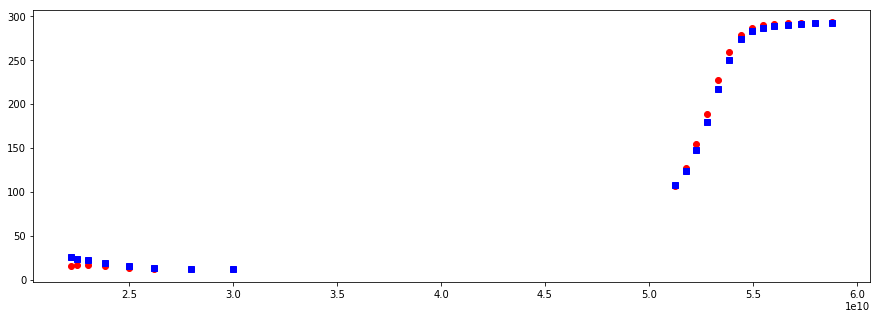

In [114]:
Tb_ARTS_ClearSky = tp.arts.xml.load("./BrightnessTemperature_ClearSky.xml")
Tb_BosungObs = np.array([26.193, 23.754, 22.435, 18.510, 
                         15.617, 12.566, 12.388, 11.472, 
                         107.09, 123.677, 147.536, 178.933, 
                         216.787, 250.225, 273.193, 282.353, 
                         286.576, 288.430, 289.69, 290.449, 
                         291.361, 291.436])
plt.plot(f_grid, Tb_ARTS_ClearSky, 'ro', f_grid, Tb_BosungObs, 'bs')
plt.gcf().set_size_inches(15,5)

In [ ]:
# ARTS test run: Monte Carlo 3D
